In [81]:
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datetime import datetime
from sklearn.model_selection import train_test_split

%run kernel_grid.ipynb

print(f'Process ID: {os.getpid()}')

5.98 μs ± 1.13 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
5.41 μs ± 250 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Started pool with 12 workers, chunk size = 21
Process ID: 1460587


In [82]:
config = Config()

In [83]:
%%time
images = []

for image_fname in tqdm(os.listdir(config.dataset_path)):
    image_fname = os.path.join(config.dataset_path, image_fname)

    # Following fuss with "with" is required to prevent "Too many open files" problem
    with Image.open(image_fname) as image:
        image.load()
        assert image.width == image.height
        assert image.mode == 'L'
        images.append((image_fname, np.array(image)))
        
    assert image.fp is None

print(f'Loaded {len(images)} images')

  0%|          | 0/9998 [00:00<?, ?it/s]

Loaded 9998 images
CPU times: user 592 ms, sys: 76 ms, total: 668 ms
Wall time: 667 ms


In [84]:
def save_grid(grid):
    if not os.path.exists(config.output_path):
        os.mkdir(config.output_path)

    stamp = datetime.now().strftime('%Y-%m-%dT%H:%M:%S')
    output_fname = os.path.join(config.output_path, f'kernel_grid{stamp}.pkl')

    with open(output_fname, 'wb') as output_file:
        pickle.dump(grid, output_file)

    print(f'Grid dumped to {output_fname}')

In [85]:
def load_last_grid():
    if not os.path.exists(config.output_path):
        return None

    candidates = []

    for fname in os.listdir(config.output_path):
        try:
            stamp = datetime.strptime(fname, 'kernel_grid%Y-%m-%dT%H:%M:%S.pkl')
            candidates.append([stamp, fname])
        except ValueError:
            print(f'Failed to parse file name {fname}')

    if not candidates:
        return None

    candidates.sort(key=lambda c: c[0], reverse=True)
    fname = os.path.join(config.output_path, candidates[0][1])

    with open(fname, 'rb') as input_file:
        grid = pickle.load(input_file)

    print(f'Grid loaded from {fname}')
    return grid

In [86]:
grid = load_last_grid()

if not grid:
    grid = KernelGrid.random(config.kernel_grid_size, config.kernel_size)

Grid loaded from out/kernel_grid2024-12-23T23:53:21.pkl


In [90]:
def get_day_images():
    train_images, _ = train_test_split(images, shuffle=True)
    return train_images

In [91]:
def enhance(extinct_waterline):
    assert extinct_waterline > 0 and extinct_waterline < 1
    
    k_perf_scores = []
    
    for ij, k in grid.indices.items():
        assert k.match_invokes > 0
        ks = k.get_stats()
        k_perf_score_mac = ks.complexity >= config.kernel_min_complexity
        k_perf_score_mac = k_perf_score_mac and ks.match_success_rate > 0
        k_perf_score = int(k_perf_score_mac) * ks.match_score
        k_perf_scores.append((k_perf_score, k, ij))
    
    k_perf_scores.sort(key=lambda x: x[0])
    extinct_list_hi = int(len(k_perf_scores) * extinct_waterline)
    assert extinct_list_hi > 0 and extinct_list_hi < len(k_perf_scores)
    extinct_list = k_perf_scores[0:extinct_list_hi]
    extinct_list_ijs = set([ij for _1, _2, ji in extinct_list])
    assert len(extinct_list) < len(k_perf_scores)
    
    new_kernels = dict()
    
    for k_perf_score, k, ij in extinct_list:
        ns = grid.get_neighbours(ij)
        possible_parents = []
    
        for n_ij, n_k in ns:
            can_spawn_children = True
            can_spawn_children = can_spawn_children and not n_ij in extinct_list_ijs
            can_spawn_children = can_spawn_children and not isinstance(n_k, FenceKernel)
            
            if can_spawn_children:
                assert n_k.match_invokes > 0, n_ij
                possible_parents.append(n_k)
    
        possible_parents.sort(key=lambda k: k.get_stats().match_success_rate, reverse=True)
        parent = None
    
        if possible_parents:
            # TODO randombly pick up parent giving favor to more performant
            parent = possible_parents[0]
    
        if parent:
            new_kernel = parent.spawn_child()
        else:
            new_kernel = Kernel.random(config.kernel_size)
    
        new_kernels[ij] = new_kernel
    
    for ij, _ in new_kernels.items():
        assert ij in grid.indices
        
    grid.indices.update(new_kernels)

In [92]:
%%time
train_stats = []

# for day in range(config.kernel_grid_evolution_days):
for day in range(25):
    # Make day impressions
    day_images = get_day_images()
    grid.reset_stats()

    for image in tqdm(day_images, desc=f'Day #{day}'):
        image_data = image[1]
        grid.perceive(image_data, config.kernel_match_threshold, config.kernel_grid_match_threshold)

    assert grid.perceive_invokes > 0
    grid_stats = grid.get_stats()
    train_stats.append(grid_stats)

    # Adjust kernels to better match day impressions
    enhance(0.5)

Day #0:   0%|          | 0/7498 [00:00<?, ?it/s]

Day #1:   0%|          | 0/7498 [00:00<?, ?it/s]

Day #2:   0%|          | 0/7498 [00:00<?, ?it/s]

Day #3:   0%|          | 0/7498 [00:00<?, ?it/s]

Day #4:   0%|          | 0/7498 [00:00<?, ?it/s]

Day #5:   0%|          | 0/7498 [00:00<?, ?it/s]

Day #6:   0%|          | 0/7498 [00:00<?, ?it/s]

Day #7:   0%|          | 0/7498 [00:00<?, ?it/s]

Day #8:   0%|          | 0/7498 [00:00<?, ?it/s]

Day #9:   0%|          | 0/7498 [00:00<?, ?it/s]

Day #10:   0%|          | 0/7498 [00:00<?, ?it/s]

Day #11:   0%|          | 0/7498 [00:00<?, ?it/s]

Day #12:   0%|          | 0/7498 [00:00<?, ?it/s]

Day #13:   0%|          | 0/7498 [00:00<?, ?it/s]

Day #14:   0%|          | 0/7498 [00:00<?, ?it/s]

Day #15:   0%|          | 0/7498 [00:00<?, ?it/s]

Day #16:   0%|          | 0/7498 [00:00<?, ?it/s]

Day #17:   0%|          | 0/7498 [00:00<?, ?it/s]

Day #18:   0%|          | 0/7498 [00:00<?, ?it/s]

Day #19:   0%|          | 0/7498 [00:00<?, ?it/s]

Day #20:   0%|          | 0/7498 [00:00<?, ?it/s]

Day #21:   0%|          | 0/7498 [00:00<?, ?it/s]

Day #22:   0%|          | 0/7498 [00:00<?, ?it/s]

Day #23:   0%|          | 0/7498 [00:00<?, ?it/s]

Day #24:   0%|          | 0/7498 [00:00<?, ?it/s]

CPU times: user 5min 39s, sys: 704 ms, total: 5min 39s
Wall time: 5min 39s


In [93]:
save_grid(grid)

Grid dumped to out/kernel_grid2024-12-24T00:05:28.pkl


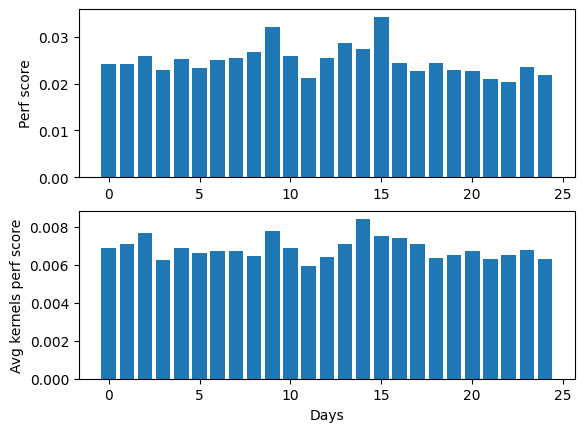

In [94]:
fig, ax = plt.subplots(2)
days_count = len(train_stats)
ax[0].bar(list(range(days_count)), [ts.perceive_success_rate for ts in train_stats])
ax[0].set_ylabel('Perf score')

ax[1].bar(list(range(days_count)), [ts.kernels_match_success_rates.mean for ts in train_stats])
ax[1].set_xlabel('Days')
ax[1].set_ylabel('Avg kernels perf score')
plt.show()


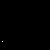
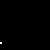
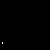
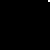
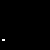
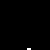
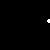
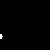
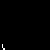
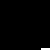
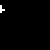
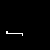
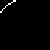
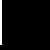
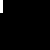
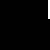
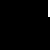
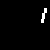
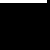
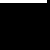
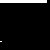
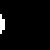
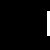
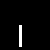
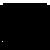
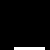
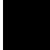
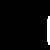
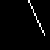
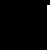
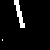
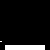
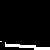
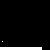
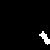
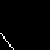
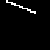
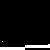
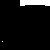
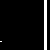
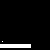
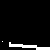
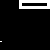
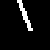
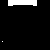
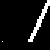
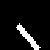
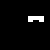
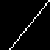
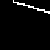
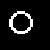
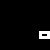
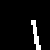
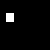
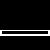
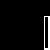
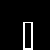
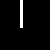
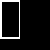
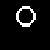
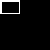
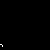
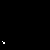
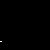
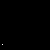
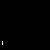
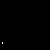
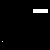
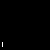
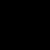
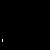
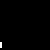
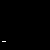
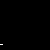
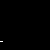
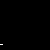
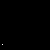
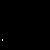
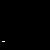
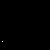
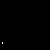
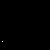
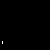
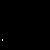
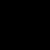
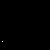
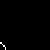
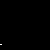
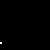
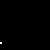
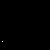
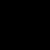
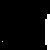
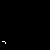
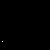
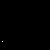
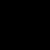
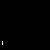
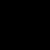
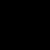
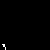
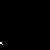
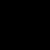
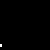
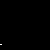
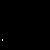
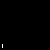
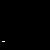
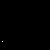
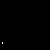
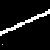
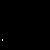
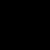
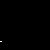
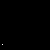
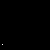
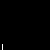
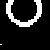
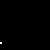
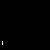
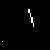
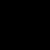
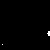
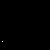
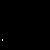
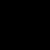
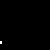
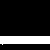
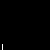
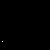
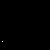
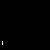
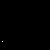
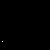
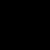
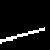
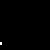
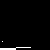
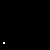
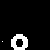
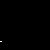
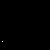
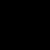
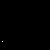
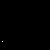
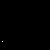
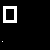
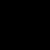
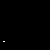
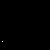
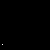
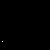
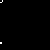
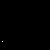
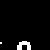
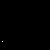
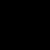
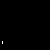
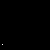
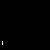
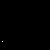
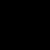
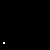
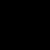
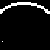
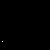
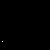
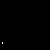
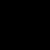
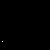
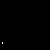
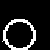
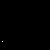
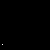
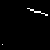
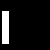
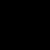
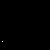
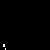
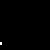
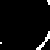
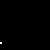
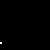
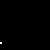
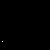
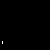
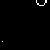
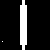
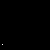
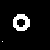
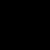
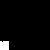
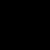
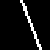
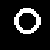
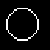
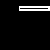
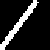
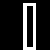
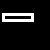
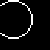
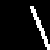
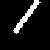
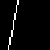
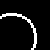
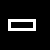
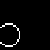
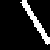
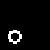
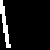
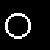
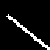
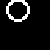
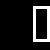
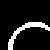
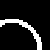
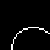
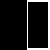
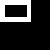
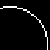
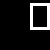
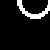
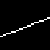
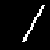
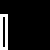
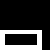
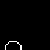
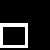
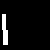
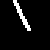
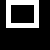
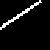
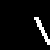
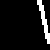
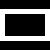
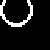
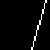
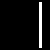
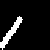
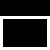
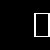
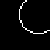
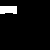
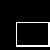
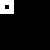
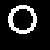
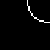
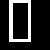
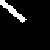
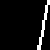
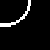
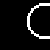
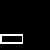
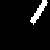
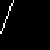
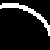

In [95]:
kernel_images = grid.get_kernel_images(1)
kernel_images.sort(key=lambda ki: ki.kernel.get_stats().match_success_rate, reverse=True)
_images = []
_captions = {}

for ki in kernel_images:
    _image = ki.image.resize((50, 50))
    _images.append(_image)
    _captions[id(_image)] = f'{ki.kernel.get_stats().match_success_rate * 100:.2f}%'

display_images_grid(_images, grid.size, captions=_captions)